In [1]:
"""导入必要的包"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn

## 1.导入MINST数据集，并进行数字化处理

In [2]:
"""导入数据，Images 2 Vectors"""
from torchvision import datasets, transforms

# images 2 Vectors 定义转换器
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])
                                ])

# 下载数据并转换
trainset = datasets.MNIST('MNIST_data/',
                         download=True,
                         train=True,
                         transform=transform)

# 定义数据加载器（可迭代对象，每次取出64个样本）
trainloader = torch.utils.data.DataLoader(trainset,
                                         batch_size=64,
                                         shuffle=True)

# 查看转换后的数据
dataiter = iter(trainloader) 
images, labels = dataiter.next()
print(type(images))  # torch.Tensor
print(images.shape)  # 64个，1厚度，28宽，28高
print(labels.shape)  # 64 表示只包含64个元素的向量

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


tensor(8)


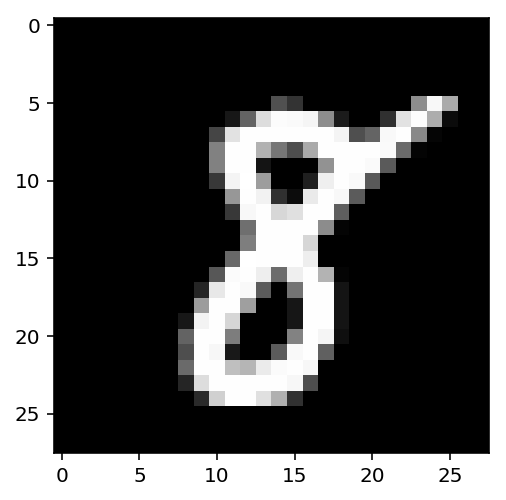

In [3]:
"""随便看一下"""
plt.imshow(images[60].numpy().squeeze(),cmap='Greys_r')  
print(labels[60])  

## 2.构建模型

In [4]:
"""构建模型"""
class Num_Identify(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(784,128)  # 输入层有784单元，即28x28
        self.h2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(x.shape[0],784)  # images 2 vector  不知道为啥输入（64，-1）会报错
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = F.softmax(self.output(x), dim=1)  # 注意，dim=1是指跨列方向求softmax,因为一行是一个样本
        return x
    
    

# 从迭代器中拿出一份（64个）样本数据
images_test, labels_test = next(iter(trainloader))

# 运行模型
my_model = Num_Identify()
output_test = my_model(images_test)

# 得到一个64x10的概率分布，注意最后一层中softmax函数输出的是一个概率分布
print(output_test.shape,images_test.shape[0])  

# 取第一个样本看，实际值为7
# 预测的概率分布0-9的概率都接近却不严格等于0.1，这是因为模型自动初始化了w和b，但可认为此时模型没有偏向选择
print("第一个样本的标签：",labels_test[0],"\n第一个样本的模型预测概率分布：\n",output_test[0])

torch.Size([64, 10]) 64
第一个样本的标签： tensor(6) 
第一个样本的模型预测概率分布：
 tensor([0.0894, 0.0911, 0.0939, 0.1170, 0.1071, 0.1155, 0.0899, 0.0867, 0.1013,
        0.1081], grad_fn=<SelectBackward>)


## 3.定义损失函数，计算损失Loss

In [5]:
"""损失函数有很多种，这里用负对数损失函数（negative log likehood loss function）"""

# 输出取对数,要去玩对数才可以放进NLLLoss中
log_output_test = torch.log(output_test)

# 定义损失函数
loss_function = nn.NLLLoss()  # nn.CrossEntropyLoss()一样的结果，但交叉熵会在前面多一步softmax,我们模型里已经有了
loss = loss_function(log_output_test,labels_test)  # 注意输入时候的顺序，前面是模型结果，后面是真实值，他们的维度是不一样的
loss,output_test.shape,labels_test.shape,images_test.shape  # 可以看到初始误差为2.3227

(tensor(2.3025, grad_fn=<NllLossBackward>),
 torch.Size([64, 10]),
 torch.Size([64]),
 torch.Size([64, 1, 28, 28]))

## 4.定义优化函数

In [6]:
from torch import optim
# 优化器需要传入模型的参数(记得加括号)和学习率，这里用批量梯度batch gradient decent下降
optimizer = optim.Adam(my_model.parameters(), lr=0.003)

## 5.反向传播，优化模型

In [7]:
# 进行损失函数的优化
epochs = 10  # 遍历整个数据集5次
for e in range(epochs):
    # 损失函数容器
    running_loss = 0
    for images, labels in trainloader: # 批次：每次取64个
        # 梯度清零
        optimizer.zero_grad()
        # 向前传播
        output = my_model(images)
        log_output = torch.log(output)
        # 计算损失
        loss = loss_function(log_output, labels)
        # 反向传播
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    
    print(f'Training loss:{running_loss/len(trainloader)}')

Training loss:0.3541419229972591
Training loss:0.17635852930300844
Training loss:0.13986058332877896
Training loss:0.12339007316915783
Training loss:0.11212804506315407
Training loss:0.1021100647736595
Training loss:0.0990405947010694
Training loss:0.0931109209909344
Training loss:0.08315628747857148
Training loss:0.08809701152327559


batch_shape
 torch.Size([64, 1, 28, 28]) label_shape
 torch.Size([64])
batch中取第29个样本 torch.Size([1, 28, 28])

真实值: tensor(9)

预测值: tensor([9])

该值预测概率: tensor([0.9996], grad_fn=<SelectBackward>)


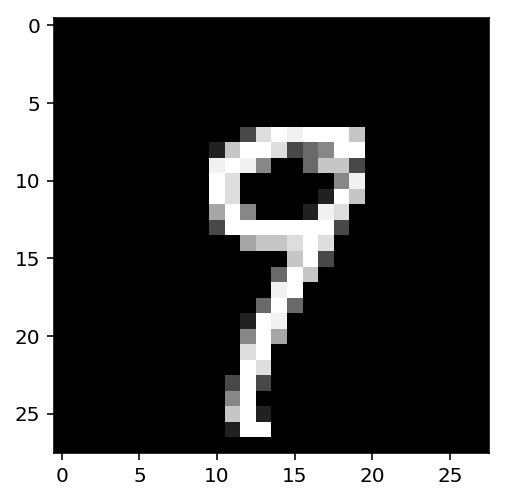

In [8]:
import random
n = random.randint(1,64)

images3,labels3 = next(iter(trainloader))
print('batch_shape\n',images3.shape,'label_shape\n',labels3.shape)

# 打印其中一个样本的shape和图形
print('batch中取第%d个样本' %n,images3[n].shape)
plt.imshow(images3[n].numpy().squeeze(),cmap='Greys_r')  

# 打印真实值
print('\n真实值:',labels3[n])  

# 打印预测值
predict_ps = my_model(images3)  # 32x10

# dim=1 也就是跨列比较，取每行最大的值top_p,以及最大的值对应的列索引top_class
top_p, top_class = predict_ps.topk(1, dim=1)  
print('\n预测值:',top_class[n])
print('\n该值预测概率:',top_p[n])

In [9]:
"""保存模型"""
# 只保存网络的参数, 官方推荐的方式
torch.save(my_model.state_dict(), 'num_identify.pkl')

"""
加载模型格式,加载为new_model(名字随便起)
new_model.load_state_dict(torch.load('？？？.pkl'))
"""

"\n加载模型格式,加载为new_model(名字随便起)\nnew_model.load_state_dict(torch.load('？？？.pkl'))\n"